In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torchvision

from google.colab import drive
drive.mount('/content/drive')
image_path = '/content/drive/My Drive/Colab Notebooks/Data/CelebA/'

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

get_smile = lambda attr: attr[31]

celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', transform=transform, download=False,target_transform=get_smile)
#celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
#celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

print('Train set:', len(celeba_train_dataset))
#print('Validation set:', len(celeba_valid_dataset))
#print('Test set:', len(celeba_test_dataset))

Mounted at /content/drive
Train set: 162770


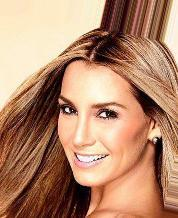

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/Data/CelebA/celeba/img_align_celeba/000001.jpg', width=100)

In [ ]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

tensor([0]) tensor([1]) tensor([1]) tensor([1]) tensor([0])


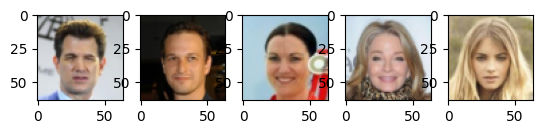

In [ ]:
epsilons = [0.01, 0.1]
pretrained_model = '/content/drive/My Drive/Colab Notebooks/models/celeba-cnn.ph'
use_cuda=True

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
#device = torch.device("cpu")

model = model.to(device)
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model,map_location="cuda").state_dict())
#model = model.to(device)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()
from torch.utils.data import Subset
from torch.utils.data import DataLoader
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(30))
test_loader = DataLoader(celeba_train_dataset, batch_size=1, shuffle=False)
#for i, datum in enumerate(iter(test_loader)):
#  print(i)
imagelist = [datum for i, datum in enumerate(iter(test_loader)) if i in [14,15,16,17,18]]
#print(imagelist)
fig, ax = plt.subplots(1,5)
ax[0].imshow(imagelist[0][0].reshape((3,64,64)).permute(1,2,0))
ax[1].imshow(imagelist[1][0].reshape((3,64,64)).permute(1,2,0))
ax[2].imshow(imagelist[2][0].reshape((3,64,64)).permute(1,2,0))
ax[3].imshow(imagelist[3][0].reshape((3,64,64)).permute(1,2,0))
ax[4].imshow(imagelist[4][0].reshape((3,64,64)).permute(1,2,0))
print(str(imagelist[0][1]) + " " + str(imagelist[1][1]) + " " +
      str(imagelist[2][1]) + " " + str(imagelist[3][1]) + " " + str(imagelist[4][1]))
#print(target)

In [ ]:
def pgd_attack(model, images, labels, eps=0.3, alpha=1/255, iters=40) :
    #images = images.to(device)
    #labels = labels.to(device)
    loss = nn.BCELoss()
    #print(images.shape)

    ori_images = images.data

    for i in range(iters) :
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        outputs= outputs.squeeze(1)
        #print("output {} label {}".format(outputs.data,labels.data))
        #print(outputs.dtype)
        #print(labels.dtype)
        cost = loss(outputs, labels)

        cost.backward()

        adv_images = images + alpha*images.grad
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        #print(images.shape)

    return images

In [ ]:

def test( model, device, test_loader, epsilon ):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        output = model(data)
        perturbed_data = pgd_attack(model, data, target.type(torch.float),eps=epsilon)


        # Set requires_grad attribute of tensor. Important for Attack
        #data.requires_grad = True
        # Forward pass the data through the model
        #output = model(data)
        init_pred = output.round() # get the index of the max log-probability
        print(init_pred)
        #print(target.shape)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        #loss = F.nll_loss(output, target)
        # Zero all existing gradients
        #model.zero_grad()
        # Calculate gradients of model in backward pass
        #loss.backward()

        #data_grad = data.grad.data
        #perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        print(output)

        # Check for success
        final_pred = output.round() # get the index of the max log-probability
        print(final_pred)
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

#torch.backends.cudnn.enabled = False

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    #print(ex)
    examples.append(ex)

tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.9048]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.9713]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.1415]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.1423]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.0140]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[0.0166]], device='cuda:0', grad_f

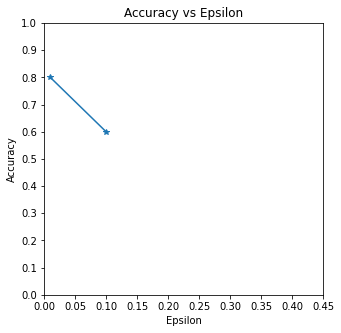

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .5, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

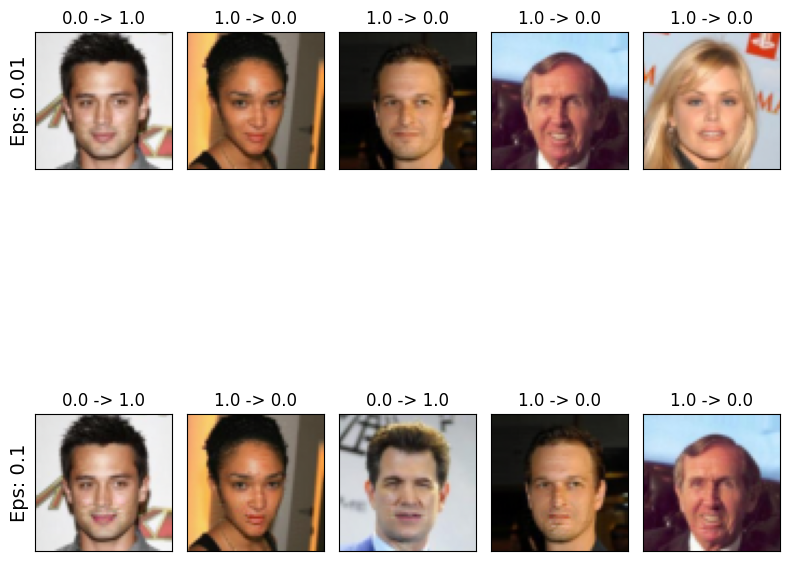

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.transpose(1,2,0))
plt.tight_layout()
plt.show()